In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from sklearn.decomposition import PCA

from utils.depth_camera import DepthCamera
from scipy.ndimage import gaussian_filter1d

plt.style.use("ggplot")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [155]:
def get_rotation_matrix(angles):
    """
    Generate a 3x3 rotation matrix given the three Euler angles in degrees.
    The Euler angles are in the order roll, pitch, and yaw (intrinsic rotations).
    """
    # Compute the sin and cos values of the angles
    c1, c2, c3 = np.cos(angles)
    s1, s2, s3 = np.sin(angles)

    # Compute the rotation matrix using the rotation matrix multiplication formula
    R_x = np.array([[1, 0, 0], [0, c1, -s1], [0, s1, c1]])
    R_y = np.array([[c2, 0, s2], [0, 1, 0], [-s2, 0, c2]])
    R_z = np.array([[c3, -s3, 0], [s3, c3, 0], [0, 0, 1]])
    R = np.dot(np.dot(R_z, R_y), R_x)

    return R

In [2]:
data_dir = "data/ios/1679048826847"

accel_df = pd.read_csv(os.path.join(data_dir, "acceleration.csv"))
gravity_df = pd.read_csv(os.path.join(data_dir, "gravity.csv"))
gyro_df = pd.read_csv(os.path.join(data_dir, "gyroscope.csv"))
attitude_df = pd.read_csv(os.path.join(data_dir, "attitude.csv"))

Correct order: pitch -> x, roll -> y, yaw -> z

Saved order: roll -> x, yaw -> y, pitch -> z

In [211]:
attitude_df.columns = ["timestamp", "y", "z", "x"]
attitude_df = attitude_df[["timestamp", "x", "y", "z"]]

In [212]:
accel_df[["x", "y", "z"]] = accel_df[["x", "y", "z"]].apply(lambda x: x * 9.81)
gravity_df[["x", "y", "z"]] = gravity_df[["x", "y", "z"]].apply(lambda x: x * 9.81)

In [213]:
imu_df = pd.merge(accel_df, attitude_df, on="timestamp", suffixes=("a", "r"))

<AxesSubplot:xlabel='Timestamp', ylabel='Attitude (rad)'>

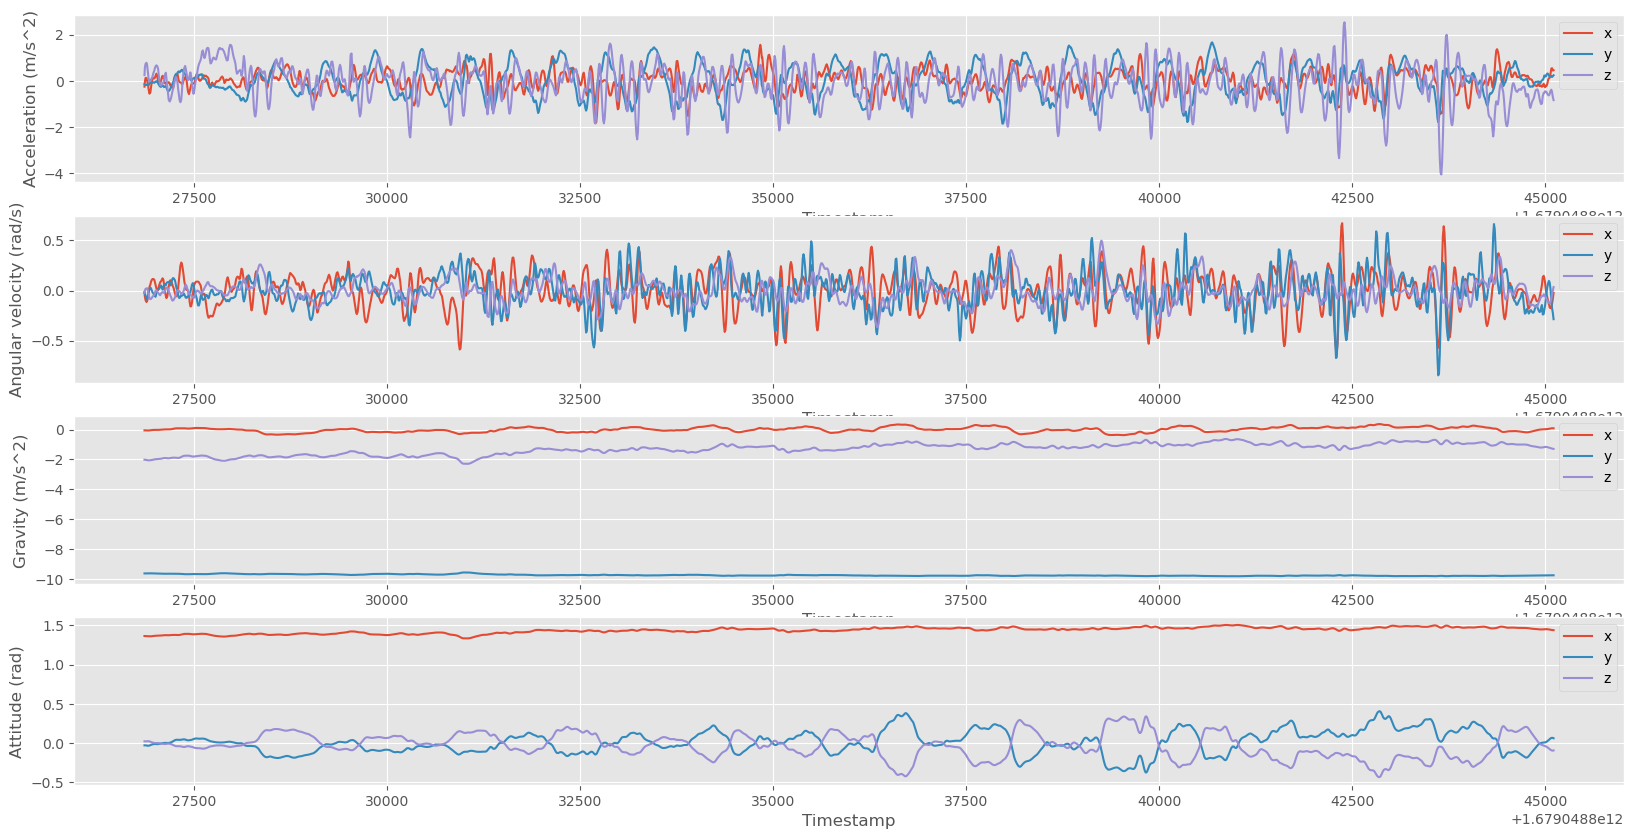

In [214]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10))

accel_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[0], xlabel="Timestamp", ylabel="Acceleration (m/s^2)")
gyro_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[1], xlabel="Timestamp", ylabel="Angular velocity (rad/s)")
gravity_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[2], xlabel="Timestamp", ylabel="Gravity (m/s^2)")
attitude_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[3], xlabel="Timestamp", ylabel="Attitude (rad)")

In [215]:
velocity_df = accel_df.copy()

velocity_df["x"] = scipy.integrate.cumtrapz(accel_df["x"], accel_df["timestamp"] / 1000, initial=0)
velocity_df["y"] = scipy.integrate.cumtrapz(accel_df["y"], accel_df["timestamp"] / 1000, initial=0)
velocity_df["z"] = scipy.integrate.cumtrapz(accel_df["z"], accel_df["timestamp"] / 1000, initial=0)

distance_df = velocity_df.copy()

distance_df["x"] = scipy.integrate.cumtrapz(velocity_df["x"], velocity_df["timestamp"] / 1000, initial=0)
distance_df["y"] = scipy.integrate.cumtrapz(velocity_df["y"], velocity_df["timestamp"] / 1000, initial=0)
distance_df["z"] = scipy.integrate.cumtrapz(velocity_df["z"], velocity_df["timestamp"] / 1000, initial=0)

In [216]:
xyz = distance_df.values[:, 1:4]
pcd_di = helpers.make_pcd(xyz)
pcd_di.paint_uniform_color([0.5, 0.5, 0.5])

open3d.visualization.draw_geometries([pcd_di])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [199]:
# compute dt in seconds
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
accel_df = accel_df.iloc[1:].copy()
# reset index in pandas data frame
accel_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
accel_df["dx"] = np.zeros(len(accel_df))
accel_df["dy"] = np.zeros(len(accel_df))
accel_df["dz"] = np.zeros(len(accel_df))

In [200]:
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(accel_df))):
    v = accel_df.iloc[i].values
    dt = v[4]
    
    d = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    accel_df.iloc[i, 5] = accel_df.iloc[i - 1, 5] + d[0]
    accel_df.iloc[i, 6] = accel_df.iloc[i - 1, 6] + d[1]
    accel_df.iloc[i, 7] = accel_df.iloc[i - 1, 7] + d[2]
    
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 986/986 [00:00<00:00, 4088.07it/s]


In [201]:
# create trajectory as a pcd
xyz = accel_df.iloc[:, 5:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

PointCloud with 987 points.

In [202]:
open3d.visualization.draw_geometries([pcd, pcd_di])

### Testing with rotation

In [174]:
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df["x"] = np.zeros(len(imu_df))
imu_df["y"] = np.zeros(len(imu_df))
imu_df["z"] = np.zeros(len(imu_df))

In [175]:
# calculate displacement and rotation
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    rotation_matrix = get_rotation_matrix([v[4], v[6], v[7]])
    
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, dd)
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 1538/1538 [00:00<00:00, 3526.52it/s]


In [176]:
# create trajectory as a pcd
xyz = imu_df.iloc[:, 8:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

PointCloud with 1539 points.

In [177]:
open3d.visualization.draw_geometries([pcd])

### Comparison with groundtruth

In [77]:
data_dir = "data/raw_data"
experiment = "exp_8"
trial = "trial_4"
subject = "subject-1"
sequence = 4

file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")

motion_dir = os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "motion")

In [78]:
accel_df = pd.read_csv(os.path.join(motion_dir, "acceleration_ios.csv"))
gravity_df = pd.read_csv(os.path.join(motion_dir, "gravity_ios.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyroscope_ios.csv"))
attitude_df = pd.read_csv(os.path.join(motion_dir, "attitude_ios.csv"))

# correcting a mistake in the data collection
attitude_df.columns = ["timestamp", "y", "z", "x"]
attitude_df = attitude_df[["timestamp", "x", "y", "z"]]

accel_df[['x', 'y', 'z']] = accel_df[['x', 'y', 'z']] * 9.81
gravity_df[['x', 'y', 'z']] = gravity_df[['x', 'y', 'z']] * 9.81

imu_df = pd.merge(accel_df, attitude_df, on="timestamp", suffixes=("a", "r"))

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 99.76 Hz


In [79]:
accel_df.loc[:, "x"] = gaussian_filter1d(accel_df.x.values, sigma=6)
accel_df.loc[:, "y"] = gaussian_filter1d(accel_df.y.values, sigma=6)
accel_df.loc[:, "z"] = gaussian_filter1d(accel_df.z.values, sigma=6)

attitude_df.loc[:, "x"] = gaussian_filter1d(attitude_df.x.values, sigma=6)
attitude_df.loc[:, "y"] = gaussian_filter1d(attitude_df.y.values, sigma=6)
attitude_df.loc[:, "z"] = gaussian_filter1d(attitude_df.z.values, sigma=6)

<AxesSubplot:xlabel='Timestamp', ylabel='Attitude (rad)'>

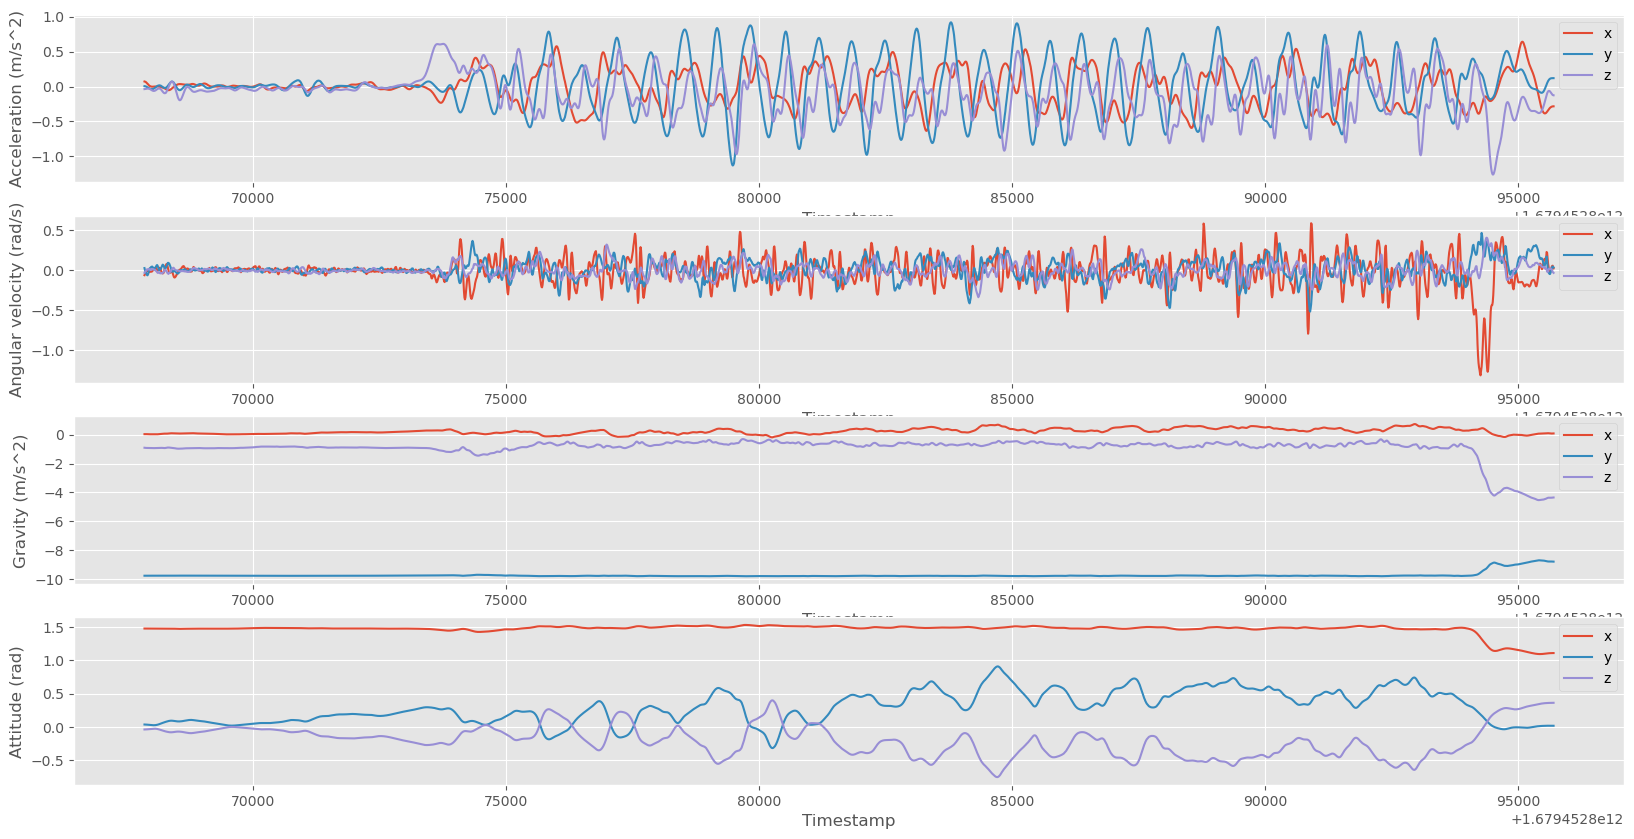

In [80]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10))

accel_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[0], xlabel="Timestamp", ylabel="Acceleration (m/s^2)")
gyro_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[1], xlabel="Timestamp", ylabel="Angular velocity (rad/s)")
gravity_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[2], xlabel="Timestamp", ylabel="Gravity (m/s^2)")
attitude_df.plot(x="timestamp", y=["x", "y", "z"], ax=ax[3], xlabel="Timestamp", ylabel="Attitude (rad)")

In [81]:
# compute dt in seconds
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
accel_df = accel_df.iloc[1:].copy()
# reset index in pandas data frame
accel_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
accel_df.loc[:, ["dx", "dy", "dz"]] = np.zeros((accel_df.shape[0], 3))

In [82]:
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(accel_df))):
    v = accel_df.iloc[i].values
    dt = v[4]
    
    d = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    accel_df.iloc[i, 5] = accel_df.iloc[i - 1, 5] + d[0]
    accel_df.iloc[i, 6] = accel_df.iloc[i - 1, 6] + d[1]
    accel_df.iloc[i, 7] = accel_df.iloc[i - 1, 7] + d[2]
    
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 2776/2776 [00:00<00:00, 3185.43it/s]


In [83]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")

# create trajectory as a pcd
xyz = accel_df.iloc[:, 5:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[0, :3, 3]))

IMU Distance:  17.725451062359
GT Distance:  14.474335024713444


In [76]:
open3d.visualization.draw_geometries([pcd])
open3d.visualization.draw_geometries([pcd_gt])

In [47]:
rx, ry, rz = np.degrees(attitude_df.iloc[0].values[1:])

init_rotation_matrix = helpers.rotate_transformation_matrix(np.identity(4), rx, ry, rz)

In [48]:
pcd.transform(init_rotation_matrix)

PointCloud with 2728 points.

In [49]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

In [127]:
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, ["dx", "dy", "dz"]] = np.zeros((imu_df.shape[0], 3))

In [128]:
# calculate displacement and rotation
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    rotation_matrix = get_rotation_matrix([v[4], v[5], v[6]])
    
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, dd)
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 2727/2727 [00:00<00:00, 3106.56it/s]


In [129]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")

# create trajectory as a pcd
xyz = imu_df.iloc[:, 8:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[0, :3, 3]))

IMU Distance:  31.599218755530185
GT Distance:  12.413537025940602


In [130]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
